Trying to make a FCN to predict dihedral angles. Some of the code adapted from Jeppe's openprotein https://github.com/biolib/openprotein. The data is from https://github.com/aqlaboratory/proteinnet casp7, text based.

In [2]:
import numpy as np
import torch
import imp
import re
from torch.nn.utils.rnn import pad_sequence

In [3]:
aa_id_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
              'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 
              'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}


In [4]:
def aa_to_onehot(aa_str, aa_to_nr, mask=None):
    """
    Onehot encode an amino acid string using a letter to number dictionary.
    The mask (from proteinnet files) is used to remove residues missing atoms
    """
    if mask!=None:
        mask_ind = np.asarray([x=='+' for x in mask])*1
        mask_ind = np.nonzero(mask_ind)
        aa_str = "".join([aa_str[x] for x in mask_ind[0]]) # the mask indices are a list in a list
    init_array = np.zeros( (len(aa_to_nr.keys()), len(aa_str)) )
    for i,j in enumerate(aa_str):
        init_array[aa_to_nr[j], i] = 1
    return(init_array)

In [5]:
def read_proteinnet_file(file, stop_at=1000, verbose=True):
    """
    Read a proteinnet file. Will also filter the 3D coordinates using the mask
    and remove proteins with chainbreaks and missing structures.
    """
    protein_dict = {}
    with open(file) as input:
        lines = input.readlines()
        curr_id = None
        for i, line in enumerate(lines):
            line = line.strip()
            if line == '[ID]':
                curr_id = lines[i+1].strip()
                protein_dict[curr_id] = {}
                protein_dict[curr_id]['primary'] = lines[i+3].strip()
            if line == '[TERTIARY]':
                coords = []
                for j in range(3):
                    coords.append(np.fromstring(lines[i+j+1], sep='\t'))
                protein_dict[curr_id]['tertiary'] = np.array(coords)
            if line == '[MASK]':
                protein_dict[curr_id]['mask'] = lines[i+1].strip()
            if len(protein_dict.keys()) >= stop_at:
                break
    filter_seqs(protein_dict, verbose)
    return(protein_dict)

In [6]:
def filter_coords(coords, mask):
    """
    coords = 3*(N*3) array, since each residue has N, CA and C
    """
    mask = np.array([x=='+' for x in mask])
    mask_stretched = np.repeat(mask, 3)
    coords_filt = coords[:, mask_stretched]
    return(coords_filt)

def filter_seqs(protein_dict, verbose):
    re_chainbreak = re.compile("\-*\+*\+\-+\+\+*\-*")
    keys_to_remove = {}
    for key in protein_dict.keys():
        if len(protein_dict[key].keys()) < 3:
            keys_to_remove[key] = ' missing structure, removing...'
            continue
        mask = protein_dict[key]['mask']
        if re_chainbreak.search(mask):
            keys_to_remove[key] = " has a chainbreak, removing..."
        else:
            coords = protein_dict[key]['tertiary']
            coords_filt = filter_coords(coords, mask)
            protein_dict[key]['tertiary'] = coords_filt
    for key in keys_to_remove.keys():
        if verbose:
            print(key, keys_to_remove[key])
        del protein_dict[key]

def new_dihedral(p0, p1, p2, p3):
    """Praxeolitic formula
    1 sqrt, 1 cross product
    
    copied from 
    https://stackoverflow.com/questions/20305272/
    dihedral-torsion-angle-from-four-points-in-cartesian-coordinates-in-python"""

    b0 = -1.0*(p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2

    # normalize b1 so that it does not influence magnitude of vector
    # rejections that come next
    b1 /= np.linalg.norm(b1)

    # vector rejections
    # v = projection of b0 onto plane perpendicular to b1
    #   = b0 minus component that aligns with b1
    # w = projection of b2 onto plane perpendicular to b1
    #   = b2 minus component that aligns with b1
    v = b0 - np.dot(b0, b1)*b1
    w = b2 - np.dot(b2, b1)*b1

    # angle between v and w in a plane is the torsion angle
    # v and w may not be normalized but that's fine since tan is y/x
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    #return np.degrees(np.arctan2(y, x))
    return np.arctan2(y, x)

def calc_angles(coords):
    N = coords.shape[1]
    angles_all = []
    for i in range(0, N-3, 3):
        psi = new_dihedral(*[coords[:, x] for x in range(i, i+4)])
        omega = new_dihedral(*[coords[:, x] for x in range(i+1, i+5)])
        phi = new_dihedral(*[coords[:, x] for x in range(i+2, i+6)])
        angles = [psi, omega, phi]
        angles_all.append(angles)
    return(np.array(angles_all))

In [7]:
train_proteins = read_proteinnet_file('/Users/Deathvoodoo/big_folders_msc/data/casp7/training_70', 2000, verbose=False)
val_proteins = read_proteinnet_file('/Users/Deathvoodoo/big_folders_msc/data/casp7/validation', 200, verbose=False)

We get onehot encoded sequences and also angles from the tertiary structures. We can pad everything to get everything in one tensor, or not.

In [12]:
def get_onehot_angles(protein_dict, pad, max_length=1500):
    """
    Get onehot sequence and calculate angles from 3d coords for the protein dictionary.
    Sometimes the angle calculation will produce nans, we remove those sequences.
    If pad==True we will numbers as tensors, otherwise lists, along with remaining ids.
    """
    remaining_ids = list(protein_dict.keys())
    sequence_list = []
    angle_list = []
    for key in protein_dict.keys():
        sequence = aa_to_onehot(protein_dict[key]['primary'], aa_id_dict, protein_dict[key]['mask'])
        coords = protein_dict[key]['tertiary']
        angles = calc_angles(coords).T
        if pad:
            if max_length-sequence.shape[0] < 0:
                print(key, ' exceeds max length: ', max_length, ' , skipping...')
                continue
            else:
                sequence_padded = np.pad(
                    sequence, pad_width = ((0,0), (0, max_length-sequence.shape[1])), 
                    constant_values = 0)
                sequence_list.append(sequence_padded)
                angles_padded = np.pad(
                    angles, pad_width = ((0,0), (0, max_length-sequence.shape[1])),
                    constant_values = 0)
                angle_list.append(angles_padded)
        else: 
            angle_list.append(angles)
            sequence_list.append(sequence)
    N = len(sequence_list)
    have_nans = []
    for i,j in enumerate(angle_list):
        if np.isnan(j).any():
            have_nans.append(i)
    inds_to_keep = np.arange(N)[np.logical_not(np.isin(np.arange(N), have_nans))].tolist()
    
    sequence_list = [sequence_list[i] for i in inds_to_keep]
    angle_list = [angle_list[i] for i in inds_to_keep]
    remaining_ids = [remaining_ids[i] for i in inds_to_keep]
    if pad:
        sequence_tensor = torch.tensor(sequence_list).float()
        sequence_tensor = sequence_tensor.unsqueeze(1)
        angle_tensor = torch.tensor(angle_list).float()
        angle_tensor = angle_tensor.unsqueeze(1)
        return([sequence_tensor, angle_tensor, remaining_ids])
    else:
        for i in range(len(sequence_list)):
            ith_seq = (torch.tensor(sequence_list[i]).float()).unsqueeze(0)
            sequence_list[i] = ith_seq.unsqueeze(0)
            ith_angles = (torch.tensor(angle_list[i]).float()).unsqueeze(0)
            angle_list[i] = ith_angles.unsqueeze(0)
        return([sequence_list, angle_list, remaining_ids])

In [60]:
train_seqs, train_angles, train_ids_remain = get_onehot_angles(train_proteins, pad=False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


In [13]:
val_seqs, val_angles, val_ids_remain = get_onehot_angles(val_proteins, pad=False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


We have to write a custom collate function because of the variable sizes (we pad minibatches to the longest sequence in the batch).

In [49]:
from torch.utils.data import Dataset
class proteindataset(torch.utils.data.Dataset):
    def __init__(self, seqs, angles):
        self.sequences = seqs
        self.angles = angles

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return [self.sequences[idx], self.angles[idx]]

def protein_collate(batch):
    seqs = [item[0] for item in batch]
    angles = [item[1] for item in batch]
    max_len = max([x.shape[3] for x in seqs])
    for i in range(len(batch)):
        curr_len = seqs[i].shape[3]
        seq_padded = np.pad(seqs[i], ((0,0), (0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        angles_padded = np.pad(angles[i], ((0,0), (0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        seqs[i] = torch.tensor(seq_padded)
        angles[i] = torch.tensor(angles_padded)
    seq_tensor = torch.cat(seqs, 0)
    angle_tensor = torch.cat(angles, 0)
    return([seq_tensor, angle_tensor])
    

In [64]:
train_dataset = proteindataset(train_seqs, train_angles)
val_dataset = proteindataset(val_seqs, val_angles)

In [65]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=100,
                                          shuffle=True, num_workers=2, collate_fn=protein_collate)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=100,
                                         shuffle=False, num_workers=2, collate_fn=protein_collate)
#testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                         #shuffle=False, num_workers=2)

We'll first try a rather simple FCN with some skip connections (torch cat parts). There's no padding done here but it would be useful to avoid short sequences not being mappable.

In [76]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(1, 3, (20, 1))
        self.bnorm0 = torch.nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(3, 6, (1, 4))
        self.bnorm1 = torch.nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 12, (1, 4))
        self.bnorm2 = torch.nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 24, (1, 6))
        self.bnorm3 = torch.nn.BatchNorm2d(24)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=24, out_channels=12, kernel_size=(1, 6))
        self.bnorm4 = torch.nn.BatchNorm2d(12)
        self.deconv2 = nn.ConvTranspose2d(in_channels=24, out_channels=6, kernel_size=(1, 4))
        self.bnorm5 = torch.nn.BatchNorm2d(6)
        self.deconv3 = nn.ConvTranspose2d(in_channels=12, out_channels=1, kernel_size=(3, 3))

    def forward(self, x):
        conv0_out = F.relu(self.bnorm0(self.conv0(x)))
        conv1_out = F.relu(self.bnorm1(self.conv1(conv0_out)))
        conv2_out = F.relu(self.bnorm2(self.conv2(conv1_out)))
        conv3_out = F.relu(self.bnorm3(self.conv3(conv2_out)))

        deconv1_out = self.bnorm4(self.deconv1(conv3_out))
        deconv2_input = torch.cat((conv2_out, deconv1_out), 1)
        deconv2_out = self.bnorm5(self.deconv2(deconv2_input))
        deconv3_input = torch.cat((conv1_out, deconv2_out), 1)
        deconv3_out = self.deconv3(deconv3_input)

        return deconv3_out



In [77]:
net = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

prints_per_epoch = 3

verbose_k = np.floor(len(trainloader)/prints_per_epoch)


train_losses = []
val_losses = []
iterations = []
best_loss = None

for epoch in range(50):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        sequence, true_angles = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_angles = net(sequence)

        loss = criterion(predicted_angles, true_angles)
        loss.backward()
        optimizer.step()
        
        # print statistics, should add validation loss
        running_loss += loss.item()
        
        if (i+1) % verbose_k == 0:   
            train_losses.append(running_loss/verbose_k)
            true_iter = len(trainloader)*epoch + i
            iterations.append(true_iter)
            net.eval()
            validation_loss = 0
            for i,j in enumerate(val_seqs):
                pred_i = net(j)
                loss_i = criterion(pred_i, val_angles[i]).item()
                validation_loss += loss_i/len(val_seqs)
            val_losses.append(validation_loss)
            net.train()
            print('epoch: {}, iteration: {}] training loss: {}, validation_loss: {}'.format(
                epoch, i, running_loss/verbose_k, validation_loss))
            
            if best_loss == None:
                best_loss = validation_loss
            else:
                if validation_loss <= min(val_losses):
                    print('new best validation loss, saving..')
                    best_loss = validation_loss
                    torch.save(net.state_dict(), 'best_fcn_parameters.pt')

            running_loss = 0.0

print('Finished Training')

epoch: 0, iteration: 160] training loss: 2.4395029544830322, validation_loss: 5.020081269815105
epoch: 0, iteration: 160] training loss: 1.8072587728500367, validation_loss: 5.082677362868507
epoch: 0, iteration: 160] training loss: 1.577377700805664, validation_loss: 5.190146058242513
epoch: 1, iteration: 160] training loss: 1.4049234867095948, validation_loss: 5.2596882589115115
epoch: 1, iteration: 160] training loss: 1.4647989988327026, validation_loss: 5.266070853108946
epoch: 1, iteration: 160] training loss: 1.329446840286255, validation_loss: 5.1939818755440115
epoch: 2, iteration: 160] training loss: 1.0883500814437865, validation_loss: 5.02831947433282
epoch: 2, iteration: 160] training loss: 1.3775933504104614, validation_loss: 4.927041095236067
new best validation loss, saving..
epoch: 2, iteration: 160] training loss: 1.5765313386917115, validation_loss: 4.846424806192055
new best validation loss, saving..
epoch: 3, iteration: 160] training loss: 1.4488956212997437, valida

epoch: 22, iteration: 160] training loss: 1.140768837928772, validation_loss: 4.296442154771795
new best validation loss, saving..
epoch: 23, iteration: 160] training loss: 0.9710819721221924, validation_loss: 4.299748931612288
epoch: 23, iteration: 160] training loss: 1.126422941684723, validation_loss: 4.291993899375014
new best validation loss, saving..
epoch: 23, iteration: 160] training loss: 1.1800942420959473, validation_loss: 4.287536752890354
new best validation loss, saving..
epoch: 24, iteration: 160] training loss: 1.004730486869812, validation_loss: 4.28780752235318
epoch: 24, iteration: 160] training loss: 1.051498293876648, validation_loss: 4.285044351719923
new best validation loss, saving..
epoch: 24, iteration: 160] training loss: 1.1551422715187072, validation_loss: 4.281744296506324
new best validation loss, saving..
epoch: 25, iteration: 160] training loss: 1.0531834602355956, validation_loss: 4.280968045596012
new best validation loss, saving..
epoch: 25, iteratio

epoch: 47, iteration: 160] training loss: 1.0508574485778808, validation_loss: 4.244014239459303
epoch: 48, iteration: 160] training loss: 1.1164234638214112, validation_loss: 4.2262165931441045
new best validation loss, saving..
epoch: 48, iteration: 160] training loss: 1.0542995929718018, validation_loss: 4.2428998932334965
epoch: 48, iteration: 160] training loss: 1.0883204817771912, validation_loss: 4.237360345650905
epoch: 49, iteration: 160] training loss: 1.1208590507507323, validation_loss: 4.234081568925277
epoch: 49, iteration: 160] training loss: 0.8895951509475708, validation_loss: 4.227632341917998
epoch: 49, iteration: 160] training loss: 1.071435821056366, validation_loss: 4.2293818989155465
Finished Training


In [85]:
net.load_state_dict(torch.load('/Users/Deathvoodoo/Documents/random/best_fcn_parameters.pt'))

net.eval()

validation_preds = [net(i) for i in val_seqs]

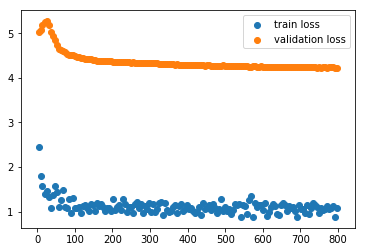

In [79]:
import matplotlib.pyplot as plt
plt.scatter(iterations, train_losses, label='train loss')
plt.scatter(iterations, val_losses, label='validation loss')
plt.legend()
plt.show()

In [81]:
import PeptideBuilder
test_protein = val_ids_remain[13]

In [90]:
test_angles_real = val_angles[13]
test_angles_pred = validation_preds[13].detach()

In [94]:
test_angles_real.shape

torch.Size([1, 1, 3, 431])

In [92]:
def make_pb_structure(seq_str, angles):
    psi = np.degrees(angles[0, :].tolist())
    omega = np.degrees(angles[1, :].tolist())
    phi = np.degrees(angles[2, :].tolist())
    structure = PeptideBuilder.make_structure(seq_str, phi, psi, omega)
    return(structure)

In [95]:
test_structure_real = make_pb_structure(val_proteins[test_protein]['primary'], test_angles_real[0, 0, :, :])

In [96]:
test_structure_pred = make_pb_structure(val_proteins[test_protein]['primary'], test_angles_pred[0, 0, :, :])

In [97]:
import Bio.PDB
def write_to_pdb(structure, prot_id, identifier):
    out = Bio.PDB.PDBIO()
    out.set_structure(structure)
    out.save(prot_id + identifier + ".pdb")

In [98]:
write_to_pdb(test_structure_real, test_protein, '_real')
write_to_pdb(test_structure_pred, test_protein, '_pred')

We can take the pdb files and align them in pymol (I have no idea how to automate this so I just did it manually and took a screenshot).

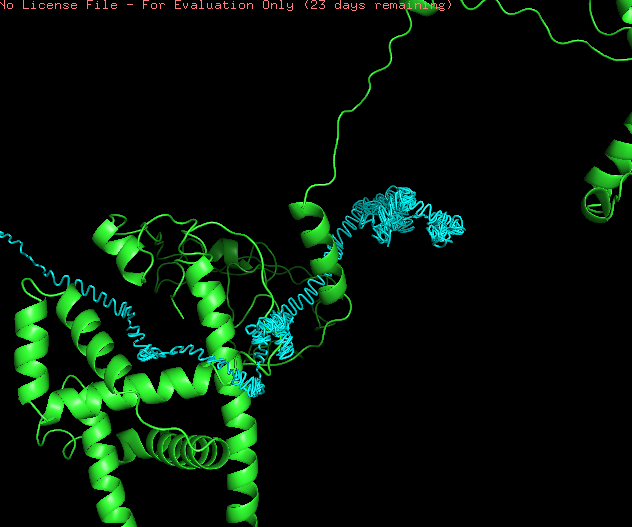

In [99]:
from IPython.display import Image 
im = Image(filename="/Users/Deathvoodoo/Documents/random/pymol_prot_fcn.png")
display(im)

Some work still needs to be done it seems...